In [1]:
import csv
import numpy as np
import os
from glob import glob
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import umap

In [ ]:
glove_data_file = 'glove.840B.300d.txt' # download from https://nlp.stanford.edu/projects/glove/
words_file = "glove.840B.300d_small.pkl"
words_big_file = "glove.840B.300d_big.pkl"

## Read Data

In [ ]:
# Run This if you have not yet run this notebook

words_big = pd.read_table(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
words = words_big.head(500000)
words.to_pickle(words_big_file)
vocab_set = set(words.index.tolist())

In [4]:
# Run this to load the words from a pre-loaded pickle file (if you've run the notebook above)

words = pd.read_pickle(words_file)
vocab_set = set(words.index.tolist())

In [6]:
import csv
from scipy.stats import pearsonr, spearmanr

def pairwise_cosine_distance(a, a_star):
    a = a/a.norm(dim=-1).unsqueeze(-1)
    a_star = a_star/a_star.norm(dim=-1).unsqueeze(-1)
    return (a.unsqueeze(1) @ a_star.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def all_to_all_cosine_distance(a, a_star):
    a = a/a.norm(dim=-1).unsqueeze(-1)
    a_star = a_star/a_star.norm(dim=-1).unsqueeze(-1)
    return a @ a_star.T

def get_word_index(word):
    try:
        return words.index.get_loc(word)
    except KeyError:
        return None
    
def get_from_index(df, indices):
    return torch.tensor(df.iloc[indices].to_numpy()).cuda()

class WordSim():
    def __init__(self, rows):
        self.rows = rows
        
    def evaluate(self, df, origin=None):
        with torch.no_grad():
            a = torch.tensor(df.loc[self.rows[0]].to_numpy()).cuda()
            a_star = torch.tensor(df.loc[self.rows[1]].to_numpy()).cuda()
            if origin is not None:
                origin = torch.tensor(origin).cuda()
                a = a - origin
                a_star = a_star - origin
            cosine_distances = pairwise_cosine_distance(a, a_star).cpu().numpy()
        scores = self.rows[2].to_list()
        sim_corr, _ = spearmanr(cosine_distances, scores)
        return sim_corr
        
    
class MTurk771(WordSim):
    def __init__(self):
        rows = self.get_mturk_word_sim()
        super().__init__(rows)
    
    def get_mturk_word_sim(self):
        rows = pd.read_csv('eval_datasets/MTURK-771.csv', header=None).reset_index(drop=True)
        keep_inds = []
        for i, r in rows.iterrows():
            keep = True
            for idx in range(2):
                if r[idx] not in vocab_set:
                    keep = False
            if keep:
                keep_inds.append(i)
        return rows.iloc[keep_inds]
    
class MEN(WordSim):
    def __init__(self):
        rows = self.get_mturk_word_sim()
        super().__init__(rows)
    
    def get_mturk_word_sim(self):
        rows = pd.read_csv('eval_datasets/MEN.txt', sep=' ', header=None).reset_index(drop=True)
        keep_inds = []
        for i, r in rows.iterrows():
            keep = True
            for idx in range(2):
                if r[idx] not in vocab_set:
                    keep = False
            if keep:
                keep_inds.append(i)
        return rows.iloc[keep_inds]
    
class Analogy():
    def eval_translation_cosine_distances(self, a1, a2, b1, b2):
        return pairwise_cosine_distance(a1-a2, b1-b2)

    
    def eval_translation_cosine_distance_acc(self, a1, a2, b1, embs):
        target = a2 - a1 + b1
        pwd = all_to_all_cosine_distance(target, embs)
        best_indices = pwd.argmax(-1)
        return best_indices
    
    
class GoogleAnalogy(Analogy):
    def __init__(self):
        self.analogy_words = self.get_word_analogy()
        
    def get_word_analogy(self):
        question_words = pd.read_csv('eval_datasets/questions-words.txt', sep=" ", header=None).dropna().reset_index(drop=True)
        keep_inds = []
        for i, r in question_words.iterrows():
            keep = True
            for idx in range(4):
                if r[idx] not in vocab_set:
                    keep = False
            if keep:
                keep_inds.append(i)
        return question_words.iloc[keep_inds]

    def evaluate(self, df):
        with torch.no_grad():
            embs = torch.tensor(df.to_numpy()).cuda()
            a1 = torch.tensor(df.loc[self.analogy_words[0]].to_numpy()).cuda()
            a2 = torch.tensor(df.loc[self.analogy_words[1]].to_numpy()).cuda()
            b1 = torch.tensor(df.loc[self.analogy_words[2]].to_numpy()).cuda()
            b2 = torch.tensor(df.loc[self.analogy_words[3]].to_numpy()).cuda()
            translation_cosine_distances = self.eval_translation_cosine_distances(a1, a2, b1, b2)
            
            bs = 1000 #1000
            N = len(a1)
            total_correct = 0
            total = 0
            for i in range(N//bs):
                print(i)
                preds = self.eval_translation_cosine_distance_acc(a1[i*bs:(i+1)*bs], a2[i*bs:(i+1)*bs], b1[i*bs:(i+1)*bs], embs)
                accs_words = np.array(df.index[preds.cpu().numpy()])
                gt = np.array(self.analogy_words[3][i*bs:(i+1)*bs].to_list())
                total_correct += len(gt[gt == accs_words])
                total += len(gt)
        return  translation_cosine_distances.mean().item(), total_correct/total 
        
ga = GoogleAnalogy()
mturk = MTurk771()
men = MEN()
    
def evaluate(df, origin=None):
    print("MTURK")
    print(mturk.evaluate(df, origin=origin))
    print("MEN")
    print(men.evaluate(df, origin=origin))
    print("Google Analogy")
#     print(ga.evaluate(df))

    

In [7]:
def compute_origin(X_):
    XX_ = X_.T @ X_
    w, v = np.linalg.eig(XX_)
    max_ind = np.argmax(w)
    return np.sqrt(w[max_ind])*v[:, [max_ind]].T
    

In [8]:
# Evaluate original dataset, reference corrected and default origin
words_origin = compute_origin(words.to_numpy())
evaluate(words)
print("=====")
evaluate(words, words_origin)

MTURK
0.7152662346409334
MEN
0.804934472292358
Google Analogy
=====
MTURK
0.6296133213751208
MEN
0.7393664163265018
Google Analogy


## Linear AE

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torch
class OneLayerLinear(nn.Module):
    def __init__(self, X, polynomial=1):
        super().__init__()
        X = torch.tensor(X)
        N = X.shape[0]
        nin = X.shape[1]
        print(nin)
        self.A = nn.Parameter(torch.zeros((nin, nin)))
        dat = X.T @ X / float(N)
        dat = dat + torch.eye(dat.shape[0])
        b_data = torch.matrix_power(dat, int(polynomial))
        self.B = nn.Parameter(b_data)
        print(self.A.shape,self.B.shape)
    
    def encode(self, x):
        hidden = self.B @ x.T
        return hidden.T
    
    def decode(self, hidden):
        out = self.A @ hidden.T
        return out.T
        
    def forward(self, x):
        hidden = self.encode(x)
        out = self.decode(hidden)
        return out, hidden
    

def compute_converged(net):
    B = net.B.data.cpu().numpy()
    w, v = np.linalg.eig(B)
    new_w = np.sqrt((w ** 2)/2 + np.sqrt(1 + (w ** 4)/4))
    new_a_w = 1/new_w
    new_B = v @ np.diag(new_w) @ v.T
    new_A = v @ np.diag(new_a_w) @ v.T
    net.A.data = torch.tensor(new_A)
    net.B.data = torch.tensor(new_B)
    return new_A, new_B
    

In [10]:
poly = 2
embeddings = torch.tensor(words.to_numpy())
net = OneLayerLinear(embeddings, poly).cuda()
compute_converged(net)

<ipython-input-9-c732db9f5b82>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


300
torch.Size([300, 300]) torch.Size([300, 300])


(array([[ 6.52443117e-01,  7.51936295e-03,  1.46686384e-03, ...,
         -2.80164144e-03,  1.75004063e-03,  1.78849679e-03],
        [ 7.51936295e-03,  6.50599171e-01,  2.02563080e-03, ...,
          6.26849441e-04,  1.05821270e-03, -2.90239471e-03],
        [ 1.46686384e-03,  2.02563080e-03,  6.59653483e-01, ...,
          1.01561987e-03,  1.45673614e-03,  3.68112518e-03],
        ...,
        [-2.80164144e-03,  6.26849441e-04,  1.01561987e-03, ...,
          6.58050430e-01,  1.46833913e-03,  1.43470387e-03],
        [ 1.75004063e-03,  1.05821270e-03,  1.45673614e-03, ...,
          1.46833913e-03,  6.59899957e-01, -3.45999331e-05],
        [ 1.78849679e-03, -2.90239471e-03,  3.68112518e-03, ...,
          1.43470387e-03, -3.45999331e-05,  6.59743077e-01]]),
 array([[ 1.66419466, -0.13998338,  0.06814787, ...,  0.08655103,
         -0.07196952, -0.07478052],
        [-0.13998338,  1.67102038, -0.07841979, ..., -0.0822678 ,
          0.06511743,  0.07907682],
        [ 0.06814787, -0.

In [11]:
with torch.no_grad():
    _, hidden = net(embeddings)
hidden = hidden.cpu()
targets = hidden.numpy()
target_df = pd.DataFrame(targets)
target_df['words'] = words.index
target_df = target_df.set_index('words')

In [12]:
# evaluate after autoencoding
net = net.cuda()
with torch.no_grad():
    _, target_origin = net(torch.tensor(words_origin).cuda())
target_origin = target_origin.cpu().numpy()
evaluate(target_df, None)
print("===")
evaluate(target_df, target_origin)

MTURK
0.2534933714086027
MEN
0.22121151771279488
Google Analogy
===
MTURK
0.6112299060852094
MEN
0.7291944315879058
Google Analogy


## Non-Linear AE

In [ ]:
import torch.nn as nn
import torch
def get_layer(nin, nout):
    c = nn.Linear(nin, nout, bias=False)
    torch.nn.init.normal_(c.weight)
    return c

class OneLayerLeakyMLP(nn.Module):
    def __init__(self, width, inp_width=300):
        super().__init__()
        self.act = nn.LeakyReLU()
        self.A = torch.nn.Linear(width, inp_width)
        self.B = torch.nn.Linear(inp_width, width)
        
    def forward(self, x):
        pre_act = self.B(x)
        post_act = self.act(pre_act)
        out = self.A(post_act)
        return out, pre_act


In [ ]:
import torch.optim as optim
def train(net, all_pts, lr):
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50000, gamma=0.5)
    ds = torch.utils.data.TensorDataset(all_pts)
    dl = torch.utils.data.DataLoader(ds, batch_size=1024)
    prev = np.infty
    i = 0
    while True:
        for (x,) in dl:
            x = x.cuda()
            optimizer.zero_grad()
            train_criterion = torch.nn.MSELoss()
            yh, _ = net(x)
            l = train_criterion(yh, x)
            l.backward()
            optimizer.step()
        scheduler.step()
        for param_group in optimizer.param_groups:
            print(l.item(), prev, prev - l.item(), param_group['lr'])
        if np.abs(prev - l.item()) < 1e-4:
            break
        prev = l.item()
        i += 1
    return net

In [ ]:
net = OneLayerLeakyMLP(400, inp_width=300).cuda().float()

In [ ]:
net = train(net, embeddings.float(), 0.1)

In [ ]:
with torch.no_grad():
    inp = embeddings.cuda().float()
    _, hidden = net(inp)
hidden = hidden.cpu()
targets = hidden.numpy()
target_df = pd.DataFrame(targets)
target_df['words'] = words.index
target_df = target_df.set_index('words')


In [ ]:
with torch.no_grad():
    _, target_origin = net(torch.tensor(words_origin).float().cuda())
target_origin = target_origin.cpu().numpy()
evaluate(target_df, None)
print("===")
evaluate(target_df, target_origin)

## Frequency Analysis

In [ ]:
XX_words = (embeddings.T @ embeddings).numpy()
w_words, v_words = np.linalg.eig(XX_words)
max_ind_words = np.argmax(w_words)
top_vec_words = torch.tensor(v_words[:, [max_ind_words]])
norm_embeddings = embeddings/torch.linalg.norm(embeddings, dim=1).unsqueeze(1)    
activations = norm_embeddings @ top_vec_words


In [ ]:
plt.hexbin(np.arange(len(activations)), activations.squeeze(1).numpy(), mincnt=1)
plt.xlabel(r"Frequency Index of $w$")
plt.ylabel(r"$\cos(w, u_1)$")
plt.savefig("top_singular_direction.pdf")
plt.show()

## Correlation Analysis

In [13]:
def get_corrs(df):
    with torch.no_grad():
        a1 = torch.tensor(df.loc[ga.analogy_words[0]].to_numpy()).cuda()
        a2 = torch.tensor(df.loc[ga.analogy_words[1]].to_numpy()).cuda()
        b1 = torch.tensor(df.loc[ga.analogy_words[2]].to_numpy()).cuda()
        b2 = torch.tensor(df.loc[ga.analogy_words[3]].to_numpy()).cuda()
        return ga.eval_translation_cosine_distances(a1, a2, b1, b2).cpu().numpy()
    

In [14]:
word_corrs = get_corrs(words)
target_corrs = get_corrs(target_df)

In [19]:
len(target_corrs[target_corrs > 0.50])/len(target_corrs)

0.7620174987133299

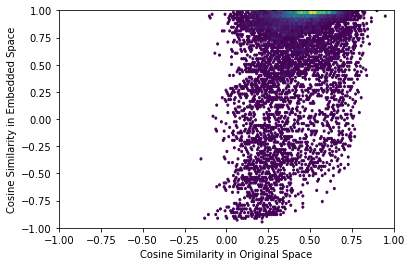

In [15]:
plt.hexbin(word_corrs, target_corrs, mincnt=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Cosine Similarity in Original Space")
plt.ylabel("Cosine Similarity in Embedded Space")
plt.savefig("glove_cos_sim_relu_k_2.pdf")
plt.show()

# Analogy Analysis

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.manifold import MDS

def get_pca(embs):
    pca = PCA(n_components=8)
    pca.fit(embs)
    transformed_emb = pca.transform(embs)
    for i in range(6):
        plt.hexbin(np.arange(len(transformed_emb)), transformed_emb[:, i], mincnt=1)
        plt.show()
    return transformed_emb

def plot_pca(latent, indices, pairs=None):
    fig, ax = plt.subplots(2, 2, figsize=(16, 2*8))
    tuples = [[(0,1), (2,3)], [(4,5), (6, 7)]]
    for i in range(2):
        for j in range(2):
            x_pca, y_pca = tuples[i][j]
            ax_ = ax[i,j]
            for idx in indices:
                ax_.scatter(latent[[idx], x_pca], latent[[idx], y_pca], color='steelblue')
                ax_.annotate(words.index[idx], (latent[idx, x_pca], latent[idx, y_pca]), alpha=0.7, fontsize='small')
                ax_.set_xlabel(f"PCA Component {x_pca}")
                ax_.set_ylabel(f"PCA Component {y_pca}")
            if pairs is not None:
                for start, end in pairs:
                    start_x, start_y = latent[start, x_pca], latent[start, y_pca]
                    end_x, end_y = latent[end, x_pca], latent[end, y_pca]
                    ax_.arrow(start_x, start_y, end_x-start_x, end_y - start_y, ls=':', color='gray')
    plt.tight_layout()
    plt.show()
    
def get_umap_transformed(embs):
    reducer = umap.UMAP(random_state=42,n_components=2)
    latent = reducer.fit_transform(embs)
    return latent

def get_mds_transformed(embs):
    reducer = MDS(random_state=42,n_components=2)
    latent = reducer.fit_transform(embs)
    return latent

def plot_latent(latent, indices, pairs=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    x_pca = 0
    y_pca = 1
    ax_ = ax
    for idx in indices:
        if idx > len(latent):
            continue
        ax_.scatter(latent[[idx], x_pca], latent[[idx], y_pca], color='steelblue')
        ax_.annotate(words.index[idx], (latent[idx, x_pca], latent[idx, y_pca]), alpha=0.7, fontsize='small')
    if pairs is not None:
        for start, end in pairs:
            if start >= len(latent) or end >= len(latent):
                continue
            start_x, start_y = latent[start, x_pca], latent[start, y_pca]
            end_x, end_y = latent[end, x_pca], latent[end, y_pca]
            ax_.arrow(start_x, start_y, end_x-start_x, end_y - start_y, ls=':', color='gray')
    plt.tight_layout()
    plt.show()

def plot_latent_dict(latent, indices, pairs=None, filename=None, xlim=None, ylim=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    x_pca = 0
    y_pca = 1
    ax_ = ax
    for idx in indices:
        latent_indiv = np.array([latent[idx]])
        ax_.scatter(latent_indiv[:, x_pca], latent_indiv[:, y_pca], color='steelblue')
        ax_.annotate(words.index[idx], (latent_indiv[0, x_pca], latent_indiv[0, y_pca]), 
                     xytext=(5, 2), textcoords='offset points', alpha=0.7, fontsize='x-large', fontfamily='sans-serif')
    if pairs is not None:
        for start, end in pairs:
            start_x, start_y = latent[start][x_pca], latent[start][y_pca]
            end_x, end_y = latent[end][x_pca], latent[end][y_pca]
            ax_.annotate("", xytext=(start_x, start_y), xy=(end_x, end_y), arrowprops=dict(arrowstyle="->", color="gray", linestyle="-"))
#             ax_.arrow(start_x, start_y, end_x-start_x, end_y - start_y, ls=':', color='gray', head_width=0.1,)
    plt.xlabel("MDS Component 1", fontfamily='sans-serif', fontsize=12)
    plt.ylabel("MDS Component 2", fontfamily='sans-serif', fontsize=12)
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [ ]:
embeddings.shape

In [ ]:
# genders: 8250:8750
# plurals: 17300:19543
# make adjective: 8755:9747
# make negative: 9748:10559
# comparative/superlative: 10560:13013
# comparative 10560:11890
ga_indices = set()
ga_pairs = set()
for i, row in enumerate(ga.analogy_words[11900:13013].iterrows()):
#     if i % 260 != 0: # uncomment to get the subset for negation
#         continue
    if i % 100 == 0:
        print(i)
    row_words = [words.index.get_loc(row[1][j]) for j in range(4)]
    for idx in row_words:
        ga_indices.add(idx)
    ga_pairs.add((row_words[0], row_words[1]))
    ga_pairs.add((row_words[2], row_words[3]))

In [ ]:
# latent_tsne = get_umap_transformed(embeddings[:30000])
# target_latent_tsne = get_umap_transformed(targets[:30000])
ga_list = np.array(list(ga_indices))
latent_tsne = get_mds_transformed(embeddings[ga_list])
latent_tsne = {ga_list[idx]: latent_tsne[idx] for idx in range(len(ga_list))}
target_latent_tsne = get_mds_transformed(targets[ga_list])
target_latent_tsne = {ga_list[idx]: target_latent_tsne[idx] for idx in range(len(ga_list))}
plot_latent_dict(latent_tsne, ga_indices, ga_pairs, "original_negation.pdf", ylim=None)
plot_latent_dict(target_latent_tsne, ga_indices, ga_pairs, "negation_linear_ae_2.pdf")
